# Setup

In [1]:
# big screen setup
# !jt -t solarizedl -cellw 1300 -fs 16 -dfs 16 -tfs 16 -ofs 16  -f consolamono

In [2]:
import pandas as pd
import datetime
import sys
import os
import numpy as np
from textblob import TextBlob
import nltk
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import pprint
import sklearn.feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import PCA

# Import Data

In [3]:
df = pd.read_csv("sms_scan_exit_survey.csv",keep_default_na=False) #leave blanks as blanks

###  dates take the place of subject labels
### Phrasing of question was changed after first six participants, much messier individual sequence responses for those first subjects, so I can either spend a bunch of time trying to organize that, ignore those subjects, or just ignore individual sequences and merge across questions

In [4]:
# rename columns
df.columns = ['Subject','Q1','Q2','Q3','Q4','Q5','Q6','Q7']
# change dates to subject labels
df.Subject = range(len(df))
# merge across questions, so all responses from each subject will be in one column
df['merged'] =  df.iloc[:, 1:].sum(axis=1)

In [5]:
df.head()

,Subject,Q1,Q2,Q3,Q4,Q5,Q6,Q7,merged
0,0,,,"Yes, I thought of a singular event that the wo...",I didn't try to think of any similar events th...,"No, they were more like short segments sewed t...",,,"Yes, I thought of a singular event that the wo..."
1,1,,,2/intact - no particular event\n3/scrambled - ...,"2/intact - yes very much, as this would be a c...","3/scrambled - no, this event in my head lasted...",No,No,2/intact - no particular event\n3/scrambled - ...
2,2,,,2 scrambled no\n3 random1 no\n4 intact no\n5 s...,2 scrambled yes\n3 random1 no\n4 intact no\n5 ...,2 scrambled no\n3 random1 yes\n4 intact yes\n5...,No problems.,I think that the problems I had were there on ...,2 scrambled no\n3 random1 no\n4 intact no\n5 s...
3,3,,,no for all,"yes for 2, 5, 6, 7, 9, 12, 13, 15 and no for t...","yes for 3, 4, 16 (kind of) and no for the rest",,"2, intact -- I realized that it was a basic d...","no for allyes for 2, 5, 6, 7, 9, 12, 13, 15 an..."
4,4,,,intact - 2 - No \n\nscramble - 3 - Yes; I ...,intact - 2 - Yes. I thought of my own experi...,intact - 2 - No\n\nscramble - 3 - No\n\nran...,No,No,intact - 2 - No \n\nscramble - 3 - Yes; I ...


# Cleanup Data

In [6]:
# make everything lowercase
df['lowered'] = df.merged.apply(str.lower)
# now remove condition labels for merged condition approach
df['cleaned'] = {x.replace('intact', '').replace('scrambled', '').replace('random','') for x in df['lowered']}
# remove all non-letter characters
drop_this = re.compile('[^a-z ]', re.MULTILINE)
df['cleaned'] = {drop_this.sub(' ', x) for x in df['cleaned']}
# tokenize cleaned responses
df['tok_merged'] = [word_tokenize(text) for text in df['cleaned']]

# lemmatizer 
# lmtzr = WordNetLemmatizer()
# this doesn't work for verbs, defaults to noun, needs to be passed the part of speech (POS)
# df['cleaned'] = [[lmtzr.lemmatize(w) for w in word_tokenize(text)] 
#             for text in df['cleaned']]
# tokenize with textblob instead
# jk that needs POS too

In [7]:
# lemmatize with POS 
# copied almost verbatim from source: https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
class LemmatizationWithPOSTagger(object):
    def __init__(self):
        pass
    def get_wordnet_pos(self,treebank_tag):
        """
        return WORDNET POS compliance to WORDNET lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # As default pos in lemmatization is Noun
            return wordnet.NOUN

    def pos_tag(self,tokens):
        # find the pos tagginf for each tokens [('What', 'WP'), ('can', 'MD'), ('I', 'PRP') ....
#         pos_tokens = [nltk.pos_tag(token) for token in tokens]
        pos_tokens = nltk.pos_tag(tokens)

        # lemmatization using pos tag   
        # convert into feature set of [('What', 'What', ['WP']), ('can', 'can', ['MD']), ... ie [original WORD, Lemmatized word, POS tag]
#         pos_tokens = [ [(word, lemmatizer.lemmatize(word,self.get_wordnet_pos(pos_tag)), [pos_tag]) for (word,pos_tag) in pos] for pos in pos_tokens]
        pos_tokens =[(word, lemmatizer.lemmatize(word,self.get_wordnet_pos(pos_tag)), [pos_tag]) for (word,pos_tag) in pos_tokens]
        return pos_tokens

In [8]:
# no dilemma, lemme get them lemmas 
lemmatizer = WordNetLemmatizer()
lmtz = LemmatizationWithPOSTagger()
df['lemmified'] = df.tok_merged.apply(lmtz.pos_tag)

In [9]:
# create new column without stems and POS, just the root word, not all that -> ('What', 'What', ['WP'])
def get_lems_only(toks):
    out = [''.join(x[:][1]) for x in toks]
    return out
# apply the func 
df['lems_only'] = df.lemmified.apply(get_lems_only)
# put all those lems back into a big chunk of text so that TfidfVectorizer will be happy later
df['chunked_lems'] = df.lems_only.apply(' '.join)

# Take a look

Mean # of tokens: 610.4166666666666


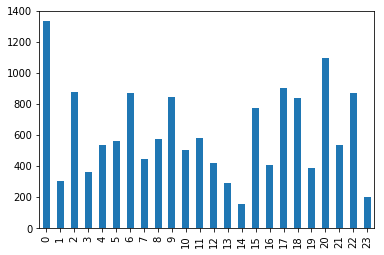

In [10]:
# plot number of tokens by subject
num_toks = df.tok_merged.apply(len)
print('Mean # of tokens:' ,np.mean(num_toks))
num_toks.plot(kind = 'bar')
plt.show()
# seems like a solid word count for almost all subjects

# Look for between subject overall differences by building a tf-idf model from all subjects

### I first tried gensim, but reached a dead end. It seems that this is more for building a corpus and then comparing new documents to the existing corpus

In [11]:
# create dictionary
dictionary = gensim.corpora.Dictionary(df['lems_only'])
# see how many words in the dictionary
len(dictionary)
# I would have thought there would be more unique words... I guess that's good? 

1320

In [12]:
# create a bag-o-words corpus 
corpus = [dictionary.doc2bow(x) for x in df['lems_only']]
# creat tf-idf model of the corpus
tf_idf = gensim.models.TfidfModel(corpus)
print(tf_idf)

TfidfModel(num_docs=24, num_nnz=4863)


In [13]:
# creat similarlity object with gensim
# get path
cwd = os.getcwd()
sims = gensim.similarities.Similarity(cwd,tf_idf[corpus],
                                      num_features=len(dictionary))
print(sims)

Similarity index with 24 documents in 0 shards (stored under /Users/WBR/walter/python_psc290/hw)


In [14]:
# now create a query from one sub's responses by first bag of words-ing
query_doc_bow = dictionary.doc2bow(df['lems_only'][1])
# then index tf_idf weights
query_doc_tf_idf = tf_idf[query_doc_bow]

In [15]:
sims[query_doc_tf_idf]

array([0.0733934 , 1.0000001 , 0.02996626, 0.18901065, 0.05149783,
       0.09683118, 0.03914526, 0.04501569, 0.05086012, 0.05375629,
       0.05838082, 0.06305377, 0.02190381, 0.38405618, 0.47268528,
       0.05326027, 0.23946717, 0.07831775, 0.08091979, 0.07964218,
       0.05693388, 0.09389637, 0.04261455, 0.03759111], dtype=float32)

### I could have done this query for each subject, then correlated the vectors, but then I found out I could this a lot more efficiently with TfidfVectorizer

In [16]:
# instantiate the model
vect = TfidfVectorizer(min_df=1, stop_words= 'english')
# fit the model
tfidf = vect.fit_transform(df['chunked_lems'])
# get the sim
pairwise_similarity = tfidf * tfidf.T
# convert form sparse to dense format
dense_pairsim = pairwise_similarity.todense()

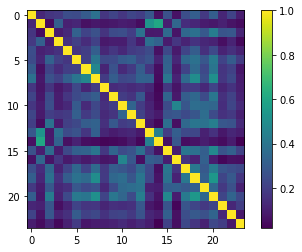

In [17]:
# make a pretty matrix
plt.imshow(dense_pairsim)
plt.colorbar()
plt.show()
# cool, looks like there could be some interestnig relationships between subjects

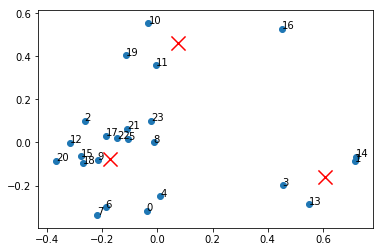

In [24]:
# old plot. adding labels to points took an insane amount of frustration and time
# plt.scatter(data2D[:,0], data2D[:,1])

# fig, ax = plt.scatter(centers2D[:,0], centers2D[:,1]), 
#             marker='x', s=200, linewidths=3, c='r')
# plt.show()

# PCA and plot in 2d, looks like 3 clusters, so mark cluster center with an X 
# make tfidf matrix dense
X = tfidf.todense()
# kluster
kmeans = KMeans(n_clusters=3).fit(X)
# PCA
pca = PCA(n_components=2).fit(X)
# get kluster centers
centers2D = pca.transform(kmeans.cluster_centers_)
# squish to 2D
data2D = pca.transform(X)
# reformat for plotsake
y = data2D[:,0].tolist()
z = data2D[:,1].tolist()
# initialize
fig, ax = plt.subplots()
ax.scatter(y,z)
# add subject labels to scatter plot
n =list(df.Subject)
for i,txt in enumerate(n):
    ax.annotate(txt, (y[i],z[i]))
# add X's at cluster centers
ax.scatter(centers2D[:,0], centers2D[:,1],marker='x', s=200, linewidths=3, c='r') 
plt.show(fig)

In [25]:
# print top terms from the kmeans clusters
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vect.get_feature_names()
for i in range(3):
    print("Cluster %d:" % i,)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print()

Top terms per cluster:
Cluster 0:
 sequence
 remember
 word
 order
 think
 event
 just
 make
 thought
 easy

Cluster 1:
 yes
 thought
 continuous
 event
 generic
 related
 verbal
 think
 pleasant
 experience

Cluster 2:
 scramble
 remember
 order
 yes
 try
 verb
 create
 make
 picture
 event

